In [1]:
import os
import re
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
plt.rcParams["font.family"] = "Arial"

In [3]:
__path__ = os.getcwd()

In [4]:
mct1_manifest = os.path.join(__path__, "mct1-graph-manifest.txt")
mct1_manifest_files = open(mct1_manifest, "r").read().split('\n')

In [5]:
mct1_results = os.path.join(__path__, "mct1_output")
mct1_result_files = next(os.walk(mct1_results), (None, None, []))[2]

In [6]:
results = {}
for f in mct1_result_files:
    results[f] = pd.read_csv(os.path.join(mct1_results, f), sep="\t")

In [7]:
_d = {}
for p in [
        "avg_noCollapse",
        "mod_noCollapse",
        "avg_collapse",
        "mod_collapse"
    ]:
        pattern =   p
        _d[pattern] = {
            "rep0": {}, 
            "rep1": {}, 
            "rep2": {}, 
            "rep3": {},
            "rep4": {}, 
            "rep5": {}
        }
        
for x in mct1_manifest_files:
    try:
        percent1 =   str(re.search('metabolomics_dropout(.*)percent_mct1_12hr_proteomics', x)[1])
        percent2 =   str(re.search('proteomics_dropout(.*)percent', x)[1])
    except:
        continue
    replicate = "rep" + re.search('percent_rep(.*).mvrs', x)[1]
    for p in [
        "avg_noCollapse",
        "mod_noCollapse",
        "avg_collapse",
        "mod_collapse"
    ]:
        pattern =   p
        try:
            this_file = 'mct1_12hr_metabolomics_dropout{0}percent_mct1_12hr_proteomics_dropout{1}percent_{2}_{3}.csv'.format(
                percent1, 
                percent2, 
                replicate, 
                pattern)
            this_df = results[this_file]
            _d[pattern][replicate][str(percent1)+"% / "+str(percent2)+"%"] = this_df[this_df.columns[2]].unique().size
        except:
            _d[pattern][replicate][str(percent1)+"% / "+str(percent2)+"%"] = np.nan
    
compiled_data = {}
for k in _d.keys():       
    data = pd.DataFrame(_d[k])
    compiled_data[k] = data.sort_index()
    
    index_list = []
    for x in compiled_data[k].index:
        this_index = []
        for y in x.split(' / '):
            if y == "0%":
                this_index.append("00%")
            else:
                this_index.append(y)
        index_list.append(' / '.join(this_index))
    compiled_data[k].index = index_list

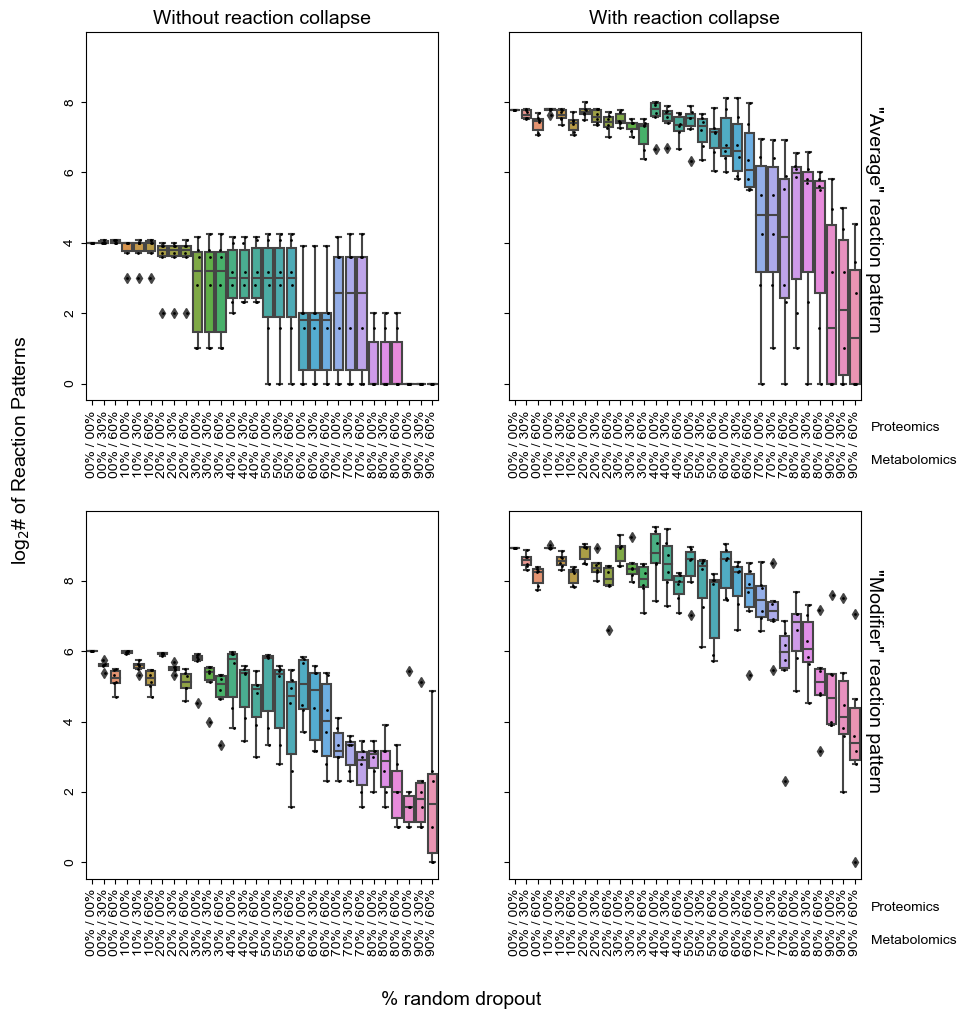

In [8]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=True, figsize=(10,11))
x_count = 0
y_count = 0
counter = 0
for c in compiled_data:
    d = np.log2(compiled_data[c] + 1).T.melt()
    sns.boxplot(data=d, x="variable", y="value", ax=axes[x_count, y_count])
    sns.stripplot(data=d, x="variable", y="value", color="black", ax=axes[x_count, y_count], size=2)
    axes[x_count, y_count].tick_params(labelrotation=90)
    axes[x_count, y_count].set_xlabel("")
    axes[x_count, y_count].set_ylabel("")
    counter += 1
    if x_count == 0:
        x_count = 1
    else:
        x_count = 0
    if counter % 2 == 0:
        y_count += 1
        
axes[0, 0].set_title("Without reaction collapse", fontsize=14)
axes[0, 1].set_title("With reaction collapse", fontsize=14)
fig.text(0.913, 0.71, '"Average" reaction pattern', fontsize=14, ha='center', va='center', rotation=-90)
fig.text(0.913, 0.29, '"Modifier" reaction pattern', fontsize=14, ha='center', va='center', rotation=-90)

fig.text(0.5, 0.0, '% random dropout', fontsize=14, ha='center', va='center')
fig.text(0.06, 0.5, 'log$_2$# of Reaction Patterns', fontsize=14, ha='center', va='center', rotation='vertical')

fig.subplots_adjust(hspace=0.3)

fig.text(0.91, 0.518, 'Proteomics', fontsize=10)
fig.text(0.91, 0.488, 'Metabolomics', fontsize=10)
fig.text(0.91, 0.081, 'Proteomics', fontsize=10)
fig.text(0.91, 0.051, 'Metabolomics', fontsize=10)

plt.savefig("sensitivity-mct1-log.png", dpi=1200, bbox_inches = 'tight')

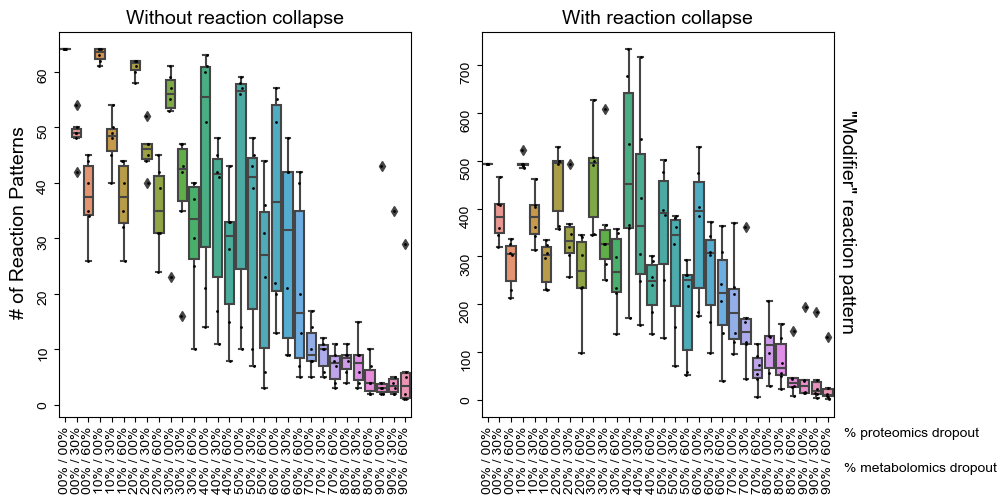

In [9]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10,5))
x_count = 0
y_count = 0
counter = 0
for c in ["mod_noCollapse", "mod_collapse"]:
    d = (compiled_data[c] + 1).T.melt()
    sns.boxplot(data=d, x="variable", y="value", ax=axes[x_count])
    sns.stripplot(data=d, x="variable", y="value", color="black", ax=axes[x_count], size=2)
    axes[x_count].tick_params(labelrotation=90)
    axes[x_count].set_xlabel("")
    axes[x_count].set_ylabel("")
    counter += 1
    if x_count == 0:
        x_count = 1
    else:
        x_count = 0
    if counter % 2 == 0:
        y_count += 1
        
axes[0].set_title("Without reaction collapse", fontsize=14)
axes[1].set_title("With reaction collapse", fontsize=14)
fig.text(0.913, 0.5, '"Modifier" reaction pattern', fontsize=14, ha='center', va='center', rotation=-90)

fig.text(0.085, 0.5, '# of Reaction Patterns', fontsize=14, ha='center', va='center', rotation='vertical')

fig.text(0.91, 0.07, '% proteomics dropout', fontsize=10)
fig.text(0.91, 0.0, '% metabolomics dropout', fontsize=10)

plt.savefig("sensitivity-mct1-modOnly.png", dpi=1200, bbox_inches = 'tight')

In [10]:
xaxis_labels = [x.get_text() for x in axes[1].get_xticklabels()]

In [11]:
xaxis_labels_c = xaxis_labels
xaxis_labels = []
for x in xaxis_labels_c:
    _label = []
    for y in x.split(" / "):
        if y == "00%":
            _label.append("0%")
        else:
            _label.append(y)
    xaxis_labels.append(' / '.join(_label))

In [12]:
# Collect percent of replicates where Fig 6 reaction ID'd

In [13]:
_d = {}
for p in [
        "avg_noCollapse",
        "mod_noCollapse",
        "avg_collapse",
        "mod_collapse"
    ]:
        pattern =   p
        _d[pattern] = pd.DataFrame(
            0,
            index=xaxis_labels,
            columns=[
                "LEU5:P38702",
                "CAT2:P32796",
                "KGD1:KGD2:LPD1:KGDH:P20967:P19262:P09624",
                "SDH:P33421:P21801:Q00711:P37298",
                "CTP1:P38152"
            ]
            )
        
for x in mct1_manifest_files:
    try:
        percent1 =   str(re.search('metabolomics_dropout(.*)percent_mct1_12hr_proteomics', x)[1])
        percent2 =   str(re.search('proteomics_dropout(.*)percent', x)[1])
    except:
        continue
    replicate = "rep" + re.search('percent_rep(.*).mvrs', x)[1]
    for p in [
        "avg_noCollapse",
        "mod_noCollapse",
        "avg_collapse",
        "mod_collapse"
    ]:
        pattern =   p
        
        this_file = 'mct1_12hr_metabolomics_dropout{0}percent_mct1_12hr_proteomics_dropout{1}percent_{2}_{3}.csv'.format(
            percent1, 
            percent2, 
            replicate, 
            pattern)
        this_df = results[this_file]
        for gene in _d[pattern].columns.tolist():
            if this_df[this_df.columns[7]].str.contains('|'.join(gene.split(":"))).any() \
            or this_df[this_df.columns[8]].str.contains('|'.join(gene.split(":"))).any():
                _d[pattern].at[str(percent1)+"% / "+str(percent2)+"%", gene] += 1

compiled_data = {}
for k in _d.keys():       
    data = pd.DataFrame(_d[k])
    compiled_data[k] = data.sort_index()
    
    index_list = []
    for x in compiled_data[k].index:
        this_index = []
        for y in x.split(' / '):
            if y == "0%":
                this_index.append("00%")
            else:
                this_index.append(y)
        index_list.append(' / '.join(this_index))
    compiled_data[k].index = index_list
    compiled_data[k].columns = ["LEU5", "CAT2", "KGD1:KGD2:LPD1", "SDH", "CTP1"]
    compiled_data[k] = compiled_data[k] / 6

ValueError: The number of FixedLocator locations (15), usually from a call to set_ticks, does not match the number of ticklabels (30).

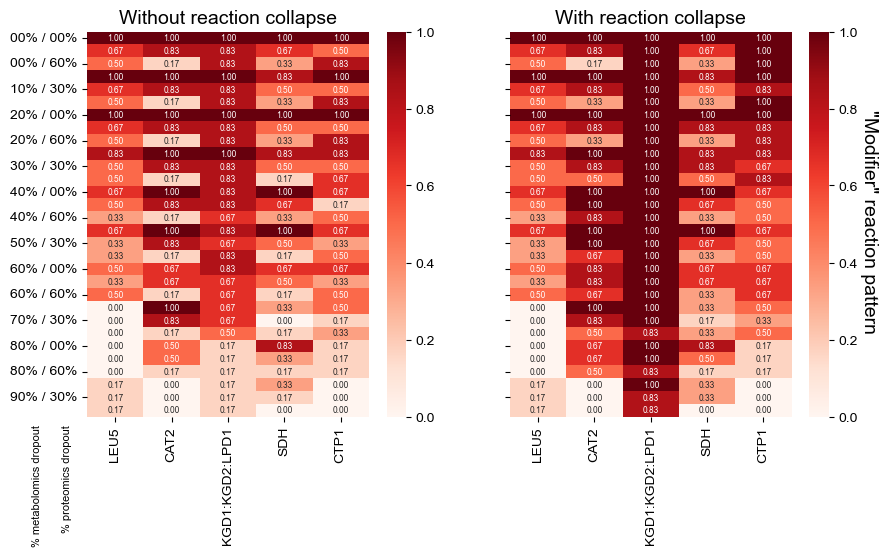

In [14]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
x_count = 0
y_count = 0
counter = 0
for c in ["mod_noCollapse", "mod_collapse"]:
    sns.heatmap(
        data=compiled_data[c], 
        cmap="Reds", 
        annot=True, fmt=".2f",
        annot_kws={"fontsize":6},
        ax=axes[x_count])
    axes[x_count].set_xticklabels(axes[x_count].get_xticklabels(), rotation=90)
    counter += 1
    if x_count == 0:
        x_count = 1
    else:
        x_count = 0
    if counter % 2 == 0:
        y_count += 1

axes[0].set_title("Without reaction collapse", fontsize=14)
axes[1].set_title("With reaction collapse", fontsize=14)
fig.text(0.907, 0.5, '"Modifier" reaction pattern', fontsize=14, ha='center', va='center', rotation=-90)

fig.text(0.075, -0.027, '% metabolomics dropout', fontsize=8, ha='center', va='center', rotation=90)
fig.text(0.105, -0.013, '% proteomics dropout', fontsize=8, ha='center', va='center', rotation=90)

axes[0].set_yticklabels(xaxis_labels_c, size = 8)
plt.savefig("sensitivity-mct1-capture.png", dpi=1200, bbox_inches = 'tight')

In [ ]:
!conda list